<a href="https://colab.research.google.com/github/Akash276/AI-Solutions/blob/master/Uplift_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings 
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
df_data = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_3/data.csv')
df_model = df_data.copy()
df_model.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [ ]:
# Checking for null data
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


In [ ]:
# Checking for object data
df_model.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [ ]:
# Checking unique object data
object_cols = [col for col in df_model.columns if df_model[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_model[obj].unique():
        print("{} {}".format(unique,sum(df_model[obj] == unique)))


 zip_code
Surburban 28776
Rural 9563
Urban 25661

 channel
Phone 28021
Web 28217
Multichannel 7762

 offer
Buy One Get One 21387
No Offer 21306
Discount 21307


In [ ]:
# Rename target column
df_model = df_model.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

In [ ]:
# One-Hot Encoding:
df_model = pd.get_dummies(df_model)

In [ ]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,treatment,target,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web
0,10,142.44,1,0,0,-1,0,0,1,0,0,1,0
1,6,329.08,1,1,1,0,0,1,0,0,0,0,1
2,7,180.65,0,1,1,-1,0,0,1,0,0,0,1
3,9,675.83,1,0,1,1,0,1,0,0,0,0,1
4,2,45.34,1,0,0,-1,0,0,0,1,0,0,1


In [ ]:
# Split data with bogo and discount
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True)
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True)

In [ ]:
# Function to declare Target Class
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df

In [ ]:
# run the functions for each treatment
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

In [ ]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()    
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
    
    
    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [ ]:
# Run the uplift function
bogo_uplift = uplift(df_model_bogo)
discount_uplift = uplift(df_model_discount)

In [ ]:
bogo_uplift

,recency,history,used_discount,used_bogo,is_referral,treatment,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,proba_CN,proba_CR,proba_TN,proba_TR,uplift_score,target_class
20765,10,211.48,1,0,0,0,0,1,0,1,0,0,0.451516,0.052382,0.451415,0.044688,-0.027751,1
7222,10,140.50,1,0,0,-1,0,0,1,0,1,0,0.474401,0.038627,0.448462,0.038510,0.007578,2
6434,4,76.25,1,0,0,-1,0,1,0,0,1,0,0.450209,0.051294,0.441745,0.056751,0.023128,2
32666,5,29.99,0,1,0,-1,1,0,0,0,1,0,0.442699,0.074099,0.383552,0.099649,0.125692,2
24212,9,248.28,1,0,0,-1,0,1,0,0,0,1,0.471690,0.073893,0.400803,0.053615,-0.034905,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14242,4,110.42,0,1,0,-1,0,0,1,0,0,1,0.443454,0.070421,0.386391,0.099734,0.136244,2
9578,2,179.98,1,0,0,-1,0,1,0,0,0,1,0.412770,0.083886,0.412435,0.090909,0.023417,2
20399,3,166.18,1,0,1,0,0,0,1,0,0,1,0.441672,0.045028,0.449297,0.064003,0.064344,0
18364,8,65.03,0,1,0,0,0,0,1,0,1,0,0.464070,0.036497,0.420649,0.078784,0.169670,0


In [ ]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

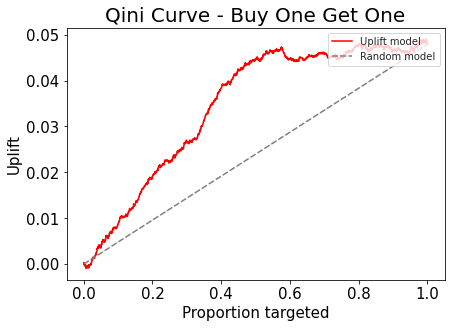

In [ ]:
# plot the Qini curve for BOGO treatment
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

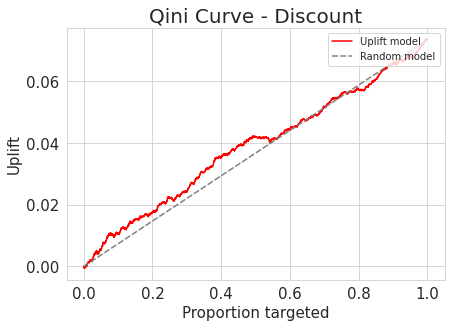

In [ ]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# data.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/content/gdrive/My Drive/Intern_ML/Data_Sets/Q_3/data.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'data.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 9 columns


In [ ]:
df1.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


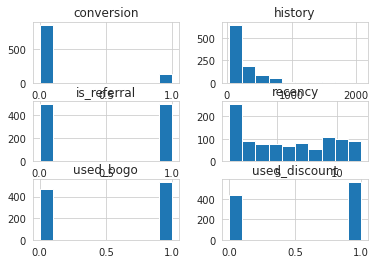

In [ ]:
hist=df1.hist()

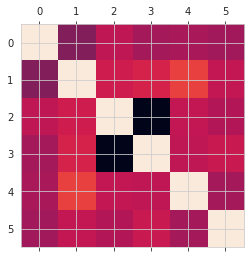

In [ ]:
plt.matshow(df1.corr())
plt.show()

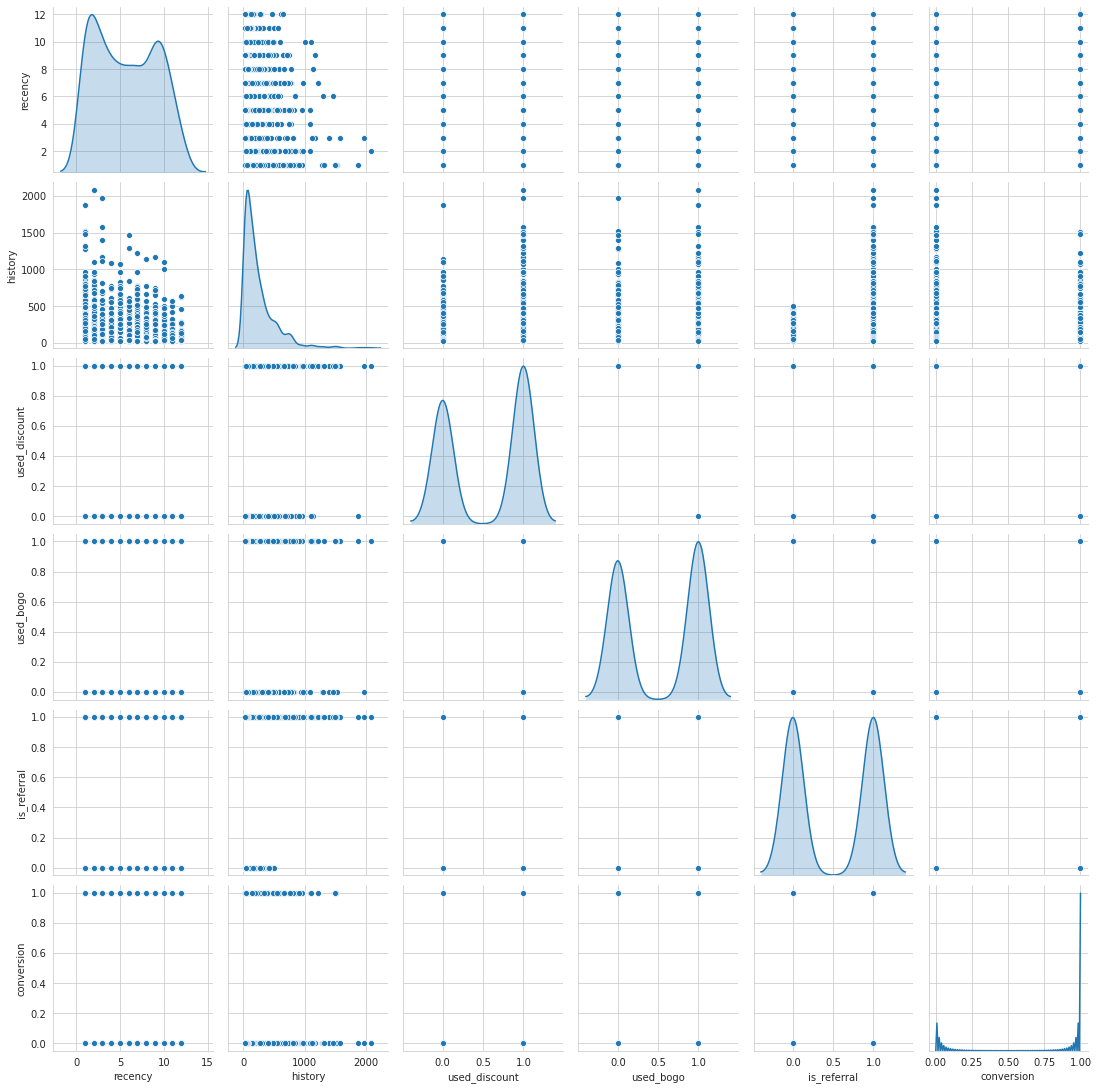

In [ ]:
#@title
import seaborn as sns
sns.pairplot(df1,diag_kind="kde")

In [ ]:
import plotly.express as px
px.scatter_matrix(df1)